# Glaze et al. model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from scipy.special import logit

In [2]:
rng = default_rng(999)

## Create synthetic data

In [3]:
def smp_trials(n_smps, rng, hazard_rate=0.1, noise=0.5, s_init=1):
    
    changes = rng.binomial(1, hazard_rate, n_smps)
    s_right = np.mod(np.cumsum(changes), 2)
    s_smps = s_init * (2 * s_right - 1)
    x_smps = s_smps + rng.normal(0, noise, n_smps)
    
    return s_smps, x_smps

In [4]:
n_trials = 100
true_h = 0.1
x_noise = 0.9

s_smps, x_smps = smp_trials(n_trials, rng, true_h, x_noise)

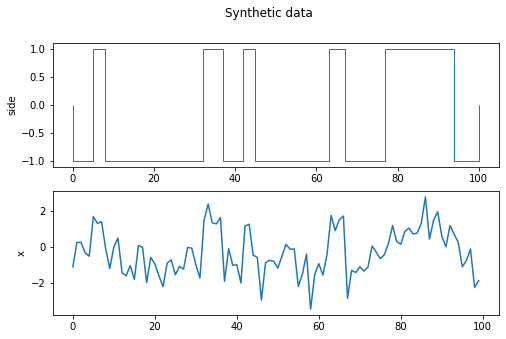

In [5]:
(fig, ax) = plt.subplots(2, 1, figsize=(8, 5))

ax[0].stairs(s_smps)
ax[0].set_ylabel('side')

ax[1].plot(x_smps)
ax[1].set_ylabel('x')

fig.suptitle('Synthetic data');

## Use filter to infer block from stimulus side

In [6]:
def phi(x, c):
    return np.log(np.exp(c + x) + 1) - np.log(np.exp(c) + np.exp(x)) 

def psi(r_prev, hazard_rate):
    return phi(r_prev, logit(1 - hazard_rate))

def log_lik(x, noise):
    return (2 * x) / (noise ** 2)

In [7]:
# Hazard rate value assumed by model
model_h = true_h

In [8]:
s_prior = np.full(n_trials, np.nan)
s_lik = np.full(n_trials, np.nan)
s_filter = np.full(n_trials, np.nan)

# Set first log-prior term to zero
s_prior[0] = 0;

for t in range(n_trials):
    
    # Compute log-likelihood ratio of observation
    s_lik[t] = log_lik(x_smps[t], x_noise)
    
    # Update filter
    s_filter[t] = s_lik[t] + s_prior[t]
    
    # Update log-prior for next time step
    if t < n_trials - 1:
        s_prior[t + 1] = psi(s_filter[t], model_h)

In [9]:
filter_est = np.sign(s_filter)
filter_err = (s_smps - filter_est) ** 2

### Filter results

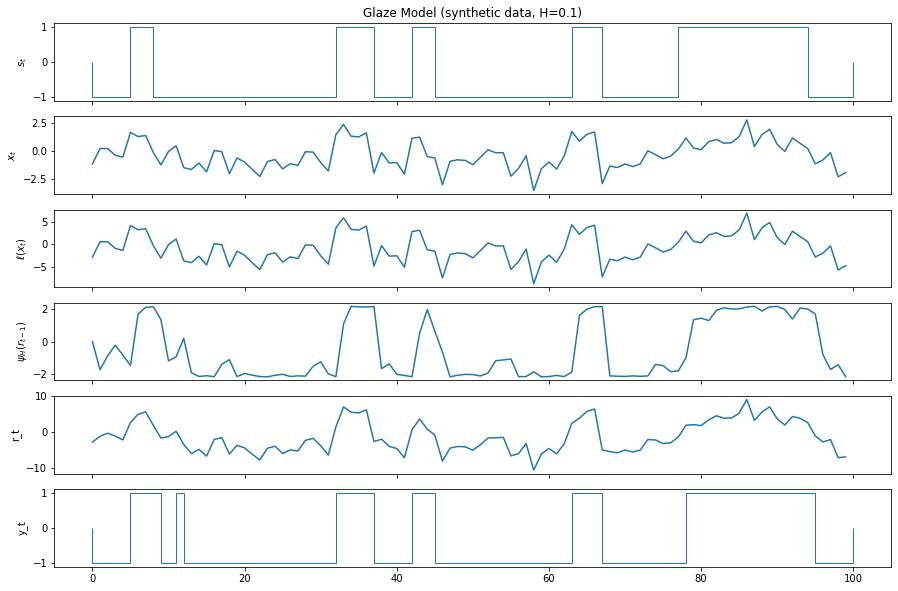

In [10]:
(fig, ax) = plt.subplots(6, 1, figsize=(15, 10), sharex=True)

ax[0].stairs(s_smps)
ax[0].set_ylabel('$s_t$')

ax[1].plot(x_smps)
ax[1].set_ylabel('$x_t$')

ax[2].plot(s_lik)
ax[2].set_ylabel('$\ell(x_t)$')

ax[3].plot(s_prior)
ax[3].set_ylabel('$\psi_H(r_{t-1})$')

ax[4].plot(s_filter)
ax[4].set_ylabel('r_t')

ax[5].stairs(filter_est)
ax[5].set_ylabel('y_t')

ax[0].set_title(f'Glaze Model (synthetic data, H={true_h})');

plt.savefig('/Users/cmcgrory/engel_lab/presentations/rotation_talk/img/glaze_synthetic.png');